# figures_draft2018a.ipynb

## Purpose
Produce figures and supplementary figures for project p17d.

## Dependencies
Python modules mentioned in next cell, inlcuding [climapy](https://github.com/grandey/climapy) ([doi:10.5281/zenodo.1053020](https://doi.org/10.5281/zenodo.1053020)) and [lib_draft2018a.py](https://github.com/grandey/p17d-sulphur-eas-eqm/blob/master/analysis_draft2018a/lib_draft2018a.py) 

## Data requirements
CESM output data, post-processed to time-series format.

## Author
Benjamin S. Grandey, 2018

In [1]:
! date

Mon Feb 12 15:11:23 +08 2018


In [2]:
import climapy
import lib_draft2018a
import ipywidgets
from IPython.display import display
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import os
import pandas as pd
from scipy import stats
import xarray as xr

# Print versions of dependencies
for package in [climapy, np, pd, xr]:
    try:
        print('{}.__version__ = {}'.format(package.__name__, package.__version__))
    except AttributeError:
        pass
print('lib_draft2018a.py is using {}'.format(lib_draft2018a.dependency_versions()))

climapy.__version__ = 0.1.0+b35937c
numpy.__version__ = 1.14.0
pandas.__version__ = 0.22.0
xarray.__version__ = 0.10.0
lib_draft2018a.py is using {'climapy': '0.1.0+b35937c', 'pandas': '0.22.0', 'xarray': '0.10.0'}


In [3]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 40  # reduce resolution of inline figures
plt.rcParams['axes.titlepad'] = 15  # increase distance to title

In [4]:
# Initialise counters to keep track of figure numbers
figure_counter = 1  # main manuscript
supp_figure_counter = 1  # supplementary figures
other_figure_counter = 1  # other figures (not included in manuscript)

In [5]:
# Load dictionaries etc from lib_draft2018a
region_bounds_dict = lib_draft2018a.load_region_bounds_dict()
region_long_dict = lib_draft2018a.load_region_long_dict()
scenario_name_dict = lib_draft2018a.load_scenario_name_dict()
variable_long_dict = lib_draft2018a.load_variable_long_dict()
variable_symbol_dict = lib_draft2018a.load_variable_symbol_dict()
variable_units_dict = lib_draft2018a.load_variable_units_dict()

In [6]:
# Longitude and latitude data used later
# Load sample data
sample_data = lib_draft2018a.load_output().isel(year=0)
# Set sample data equal to one - here, we are just interested in lat-lon info
sample_data[:] = 1.
# Shift longitudes
sample_data = climapy.xr_shift_lon(sample_data, lon_min=-179)
# Longitude and latitude data
lon = sample_data['lon']
lat = sample_data['lat']
# Lower bound for first longitude bin (important for map)
lon0 = (lon[0] - (lon[1]-lon[0])/2.0).values
# Pseudo-lower bound for first latitude bin (used for stretching imshow)
lat0 = (lat[0] - (lat[1]-lat[0])/2.0).values

/Users/grandey/anaconda/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


## Function to produce emissions bar chart

/Users/grandey/anaconda/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):
/Users/grandey/anaconda/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):
/Users/grandey/anaconda/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):
/Users/grandey/anaconda/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument 

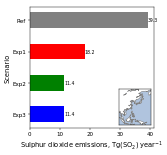

In [7]:
def emissions_bars(species='so2tot',
                   title=None,
                   xlabel=r'Sulphur dioxide emissions, Tg(SO$_2$) year$^{-1}$',
                   xlim=None,
                   ylabel=True,
                   region='ESEAs',
                   map_inset=True,
                   ax=None):
    # Create Axes if no Axes passed as an argument
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    # Dataframe to hold regional totals
    data_df = pd.DataFrame(columns=('scenario', 'scenario_name', 'regional_total'))
    # Loop over scenarios
    for scenario in ['2000', 'eas0', 'eas0b', 'eas0c']:
        # Load emissions
        if species == 'so2tot':
            data = (lib_draft2018a.load_emissions(species='so2', surf_or_elev='both',
                                                  scenario=scenario, season='annual') +
                    lib_draft2018a.load_emissions(species='so4_a1', surf_or_elev='both',
                                                  scenario=scenario, season='annual') +
                    lib_draft2018a.load_emissions(species='so4_a2', surf_or_elev='both',
                                                  scenario=scenario, season='annual'))
        else:
            data = lib_draft2018a.load_emissions(species=species, surf_or_elev='both',
                                                 scenario=scenario, season='annual')
        # Calculate regional total
        lon_bounds, lat_bounds = region_bounds_dict[region]
        data = climapy.xr_area_weighted_stat(data, stat='sum', lon_bounds=lon_bounds,
                                             lat_bounds=lat_bounds).values / 1e12
        # Append to data_df
        data_df = data_df.append({'scenario': scenario, 
                                  'scenario_name': scenario_name_dict[scenario],
                                  'regional_total': data},
                                  ignore_index=True)
    # Plot bars
    ax.barh(data_df.index, data_df['regional_total'], height=0.5,
            color=['0.5', 'r', 'g', 'b'])
    # Axes
    ax.set_yticks(data_df.index)
    ax.set_yticklabels(data_df['scenario_name'])
    plt.gca().invert_yaxis()
    if ylabel:
        ax.set_ylabel('Scenario', fontsize='large')
    if xlabel:
        ax.set_xlabel(xlabel, fontsize='large')
    if xlim:
        ax.set_xlim(xlim)
    # Annotate with values
    for i in data_df.index:
        text = '{:.1f}'.format(data_df.loc[i, 'regional_total'])
        ax.text(data_df.loc[i, 'regional_total'], i,
                text, verticalalignment='center',
                horizontalalignment='left', fontsize='small')
    # Title
    if title:
        ax.set_title(title)
    # Insert map
    if map_inset:
        ax2 = inset_axes(ax, width='30%', height='30%', loc=4)
        ax2.set_facecolor('lightsteelblue')
        anchor = 'SE'
        if region == 'Globe':
            lon_bounds = [lon0, lon0+360.]
            lat_bounds = [-90.0, 90.0]
        else:
            lon_bounds, lat_bounds = region_bounds_dict[region]
        bm = Basemap(llcrnrlat=lat_bounds[0], urcrnrlat=lat_bounds[1],
                     llcrnrlon=lon_bounds[0], urcrnrlon=lon_bounds[1],
                     anchor=anchor)
        bm.drawcoastlines(color='0.5')
        bm.fillcontinents(color='white')
    return ax

# Examples
if True:
    emissions_bars()

## Emissions bar chart composite figure

/Users/grandey/anaconda/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):
/Users/grandey/anaconda/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):
/Users/grandey/anaconda/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):
/Users/grandey/anaconda/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument 

Written local/f01.pdf


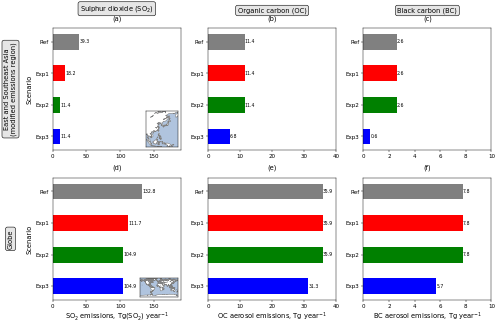

In [8]:
# Set up figure
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 3)
# Sulphur dioxide bar charts
species = 'so2tot'
xlabel = r'SO$_2$ emissions, Tg(SO$_2$) year$^{-1}$'
xlim = [0, 190]
ax1 = emissions_bars(species=species, title='(a)',
                     xlabel=None, xlim=xlim, ylabel=True,
                     region='ESEAs', map_inset=True,
                     ax=plt.subplot(gs[0, 0]))
ax2 = emissions_bars(species=species, title='(d)',
                     xlabel=xlabel, xlim=xlim, ylabel=True,
                     region='Globe', map_inset=True,
                     ax=plt.subplot(gs[1, 0]))
# Organic carbon bar charts
species = 'oc'
xlabel = r'OC aerosol emissions, Tg year$^{-1}$'
xlim = [0, 40]
ax3 = emissions_bars(species=species, title='(b)',
                     xlabel=None, xlim=xlim, ylabel=False,
                     region='ESEAs', map_inset=False,
                     ax=plt.subplot(gs[0, 1]))
ax4 = emissions_bars(species=species, title='(e)',
                     xlabel=xlabel, xlim=xlim, ylabel=False,
                     region='Globe', map_inset=False,
                     ax=plt.subplot(gs[1, 1]))
# Black carbon bar charts
species = 'bc'
xlabel = r'BC aerosol emissions, Tg year$^{-1}$'
xlim = [0, 10]
ax5 = emissions_bars(species=species, title='(c)',
                     xlabel=None, xlim=xlim, ylabel=False,
                     region='ESEAs', map_inset=False,
                     ax=plt.subplot(gs[0, 2]))
ax6 = emissions_bars(species=species, title='(f)',
                     xlabel=xlabel, xlim=xlim, ylabel=False,
                     region='Globe', map_inset=False,
                     ax=plt.subplot(gs[1, 2]))
# Column titles
for ax, title in zip([ax1, ax3, ax5],
                     [r'Sulphur dioxide (SO$_2$)',
                      r'Organic carbon (OC)',
                      r'Black carbon (BC)']):
    ax.text(0.5, 1.12, title,
            transform=ax.transAxes, fontsize='large',
            verticalalignment='bottom', horizontalalignment='center',
            bbox={'boxstyle': 'round, pad=0.3', 'fc': '0.9', 'ec': 'k'})
# Row titles
for ax, title in zip([ax1, ax2],
                     ['East and Southeast Asia\n(modified emissions region)',
                      'Globe']):
    ax.text(-0.33, 0.5, title,
            transform=ax.transAxes, fontsize='large', rotation=90,
            verticalalignment='center', horizontalalignment='center',
            bbox={'boxstyle': 'round, pad=0.3', 'fc': '0.9', 'ec': 'k'})
# Prevent overlapping labels
fig.tight_layout()
# Save figure
ofilename = 'local/f{:02}.pdf'.format(figure_counter)
fig.savefig(ofilename, bbox_inches='tight', dpi=300)
print('Written {}'.format(ofilename))
figure_counter += 1

## Function to produce zonal mean line plot of differences

/Users/grandey/anaconda/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):
/Users/grandey/anaconda/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):
/Users/grandey/anaconda/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):
/Users/grandey/anaconda/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument 

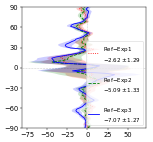

In [9]:
def zonal_mean_line_plot(variable='PRECC+PRECL',
                         f_or_b='b',
                         xlabel=None,
                         xlim=None,
                         ylabel=None,
                         mean_format='${:+.2f}\pm{:.2f}$',
                         title=None,
                         ax=None):
    # Create Axes if no Axes passed as an argument
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    # Load data for reference scenario
    ref_data = lib_draft2018a.load_output(variable=variable, scenario='2000',
                                          f_or_b=f_or_b,
                                          season='annual', apply_sf=True)
    ref_zm = ref_data.mean(dim='lon')  # zonal mean
    ref_awm = climapy.xr_area_weighted_stat(ref_data)  # area-weighted means
    ref_data.close()
    # Loop over other scenarios
    for scenario, c, linestyle in zip(['eas0', 'eas0b', 'eas0c'],
                                      ['r', 'g', 'b'],
                                      [':', '--', '-']):
        # Load data
        data = lib_draft2018a.load_output(variable=variable, scenario=scenario,
                                          f_or_b=f_or_b,
                                          season='annual', apply_sf=True)
        zm = data.mean(dim='lon')
        awm = climapy.xr_area_weighted_stat(data)
        data.close()
        # Area-weighted mean diff and error - used for legend label
        awm_diff = (ref_awm.mean(dim='year').data -
                    awm.mean(dim='year').data)
        error1 = (ref_awm.std(dim='year', ddof=1).data.flatten() /
                  np.sqrt(ref_awm['year'].size))
        error2 = (awm.std(dim='year', ddof=1).data.flatten() /
                  np.sqrt(awm['year'].size))
        error = float(np.sqrt(error1**2 + error2**2))
        # Legend label
        label = ('Ref$-${}\n'.format(scenario_name_dict[scenario]) +
                 mean_format.format(awm_diff, error))
        # Plot line - showing mean diff across time
        diff = (ref_zm.mean(dim='year').data.flatten()  # Ref - scenario
                - zm.mean(dim='year').data.flatten())
        ax.plot(diff, zm['lat'].data,
                c=c, linestyle=linestyle, alpha=1,
                label=label)
        # Plot shading - showing standard error
        error1 = (ref_zm.std(dim='year', ddof=1).data.flatten() /
                  np.sqrt(ref_zm['year'].size))
        error2 = (zm.std(dim='year', ddof=1).data.flatten() /
                  np.sqrt(zm['year'].size))
        error = np.sqrt(error1**2 + error2**2)
        ax.fill_betweenx(zm['lat'].data, diff-error, diff+error,
                         facecolor=c, alpha=0.2)
    # Lines showing zero
    ax.axhline(0, c='k', alpha=0.2, linewidth=1, linestyle='--')
    ax.axvline(0, c='k', alpha=0.2, linewidth=1, linestyle='--')
    # y-axis
    plt.yticks(fontsize='large')
    ax.set_ylim([-90, 90])
    ax.set_yticks(np.arange(-90, 91, 30))
    if ylabel:
        ax.set_ylabel(r'Latitude, $^\circ$N', fontsize='x-large')
    # x-axis
    plt.xticks(fontsize='large')
    if xlabel:
        ax.set_xlabel(xlabel, fontsize='x-large')
    if xlim:
        ax.set_xlim(xlim)
    # Title and legend
    if title:
        ax.set_title(title, fontsize='x-large')
    ax.legend(loc=4, labelspacing=2)
    return ax

# Example
if True:
    zonal_mean_line_plot()

## Function to produce maps of differences

/Users/grandey/anaconda/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):
/Users/grandey/anaconda/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):
/Users/grandey/anaconda/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):
/Users/grandey/anaconda/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument 

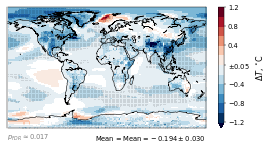

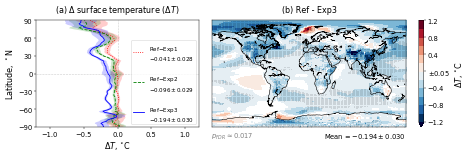

In [10]:
def difference_map(variable='TS',
                   f_or_b='b',
                   ref_scenario='2000', scenario='eas0c',
                   vlim=[-1.2, 1.2], whiteout='0.05',
                   cmap_name='RdBu_r', nlev=12, colorbar=True,
                   mean_format='Mean$={:+.3f}\pm{:.3f}$',
                   title=None,
                   ax=None):
    # Create Axes if no Axes passed as an argument
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    # Discretise colormap and set over/under
    cmap = plt.cm.get_cmap(cmap_name, nlev)
    if cmap_name == 'RdBu_r':
        cmap.set_under([0, 0, 0.25])
        cmap.set_over([0.25, 0, 0])
    # Load data for scenario
    data = lib_draft2018a.load_output(variable=variable,
                                      scenario=scenario,
                                      f_or_b=f_or_b,
                                      season='annual',
                                      apply_sf=True)
    data = climapy.xr_shift_lon(data, lon_min=-179.)  # shift longitudes
    # Load data for reference scenario
    ref_data = lib_draft2018a.load_output(variable=variable,
                                          scenario=ref_scenario,
                                          f_or_b=f_or_b,
                                          season='annual',
                                          apply_sf=True)
    ref_data = climapy.xr_shift_lon(ref_data, lon_min=-179.)  # shift longitudes
    # Calculate means across time
    tm = data.mean(dim='year').data
    ref_tm = ref_data.mean(dim='year').data
    tm_diff = ref_tm - tm  # difference, Ref - scenario
    # Find where statistically significant and larger than whiteout value
    p_values = stats.ttest_ind(data.data,
                               ref_data.data,
                               equal_var=False)[1]  # Welch's t-test
    if np.isnan(p_values).any():  # check for NaNs in p_values and replace with ones...
        w_replace = (np.where(np.isnan(p_values) &
                              (tm_diff == 0.)))  #... if tm_diff is zero
        p_values[w_replace] = 1.
    p_fdr = climapy.stats_fdr(p_values,
                              alpha=0.05)  # p-value threshold for alpha=0.05
    w_sig = np.where((p_values.ravel() <= p_fdr) &  # statistically significant &
                     (np.abs(tm_diff.ravel()) >  # larger than whiteout value
                      float(whiteout)))
    lon_sig, lat_sig = np.meshgrid(data['lon'].data, data['lat'].data)
    lon_sig = lon_sig.ravel()[w_sig]
    lat_sig = lat_sig.ravel()[w_sig]
    # Map
    bm = Basemap(llcrnrlat=-90.0, urcrnrlat=90.0,
                 llcrnrlon=lon0, urcrnrlon=360.0+lon0, ax=ax)
    bm.drawcoastlines(ax=ax)
    # Plot field and stippling
    tm_diff_masked = np.ma.masked_inside(tm_diff, -1*float(whiteout),
                                         float(whiteout))
    im = ax.imshow(tm_diff_masked,
                   extent=[lon0, 360+lon0, -lat0, lat0],
                   vmin=vlim[0], vmax=vlim[1], cmap=cmap, aspect='auto')
    ax.scatter(lon_sig, lat_sig, marker='.', s=0.05, c='k')
    # Annotate with p-value threshold
    ax.text(-180, -105, r'$p_{{FDR}}\approx{:.3f}$'.format(p_fdr),
            color='0.5', horizontalalignment='left', verticalalignment='center',
            fontsize='large')
    # Annotate with area-weighted mean
    mean_list = []  # list to hold area-weighted means
    error_list = []  # list to hold standard errors on means
    for d in [ref_data, data]:
        awm = climapy.xr_area_weighted_stat(d)
        mean_list.append(awm.mean(dim='year').data)
        error = (awm.std(dim='year', ddof=1).data.flatten() /
                 np.sqrt(awm['year'].size))
        error_list.append(error)
    mean_diff = mean_list[0] - mean_list[1]
    error = float(np.sqrt(error_list[0]**2 + error_list[1]**2))  # combine errors
    ax.text(180, -105, 'Mean = '+mean_format.format(mean_diff, error),
            color='k', horizontalalignment='right', verticalalignment='center',
            fontsize='large')
    # Colorbar
    if colorbar:
        if tm_diff.min() < vlim[0] and tm_diff.max() > vlim[1]:
            extend = 'both'
        elif tm_diff.min() < vlim[0]:
            extend = 'min'
        elif tm_diff.max() > vlim[1]:
            extend = 'max'
        else:
            extend = 'neither'
        ticks = np.arange(vlim[0], vlim[1]+1e-10, (vlim[1]-vlim[0])/(nlev/2))
        cbar = plt.colorbar(im, ticks=ticks, extend=extend)
        if float(whiteout) != 0:
            tick_labels = [item.get_text() for item in cbar.ax.get_yticklabels()]
            tick_labels[int(nlev/4)] = r'$\pm$' + whiteout
            cbar.ax.set_yticklabels(tick_labels, fontsize='large')
        label = '{}, {}'.format(variable_symbol_dict[variable],
                                variable_units_dict[variable])
        cbar.set_label(label, fontsize='x-large', labelpad=7)
    # Close datasets
    for d in [ref_data, data]:
        d.close()
    # Title
    if title:
        ax.set_title(title, fontsize='x-large')
    return ax, im, tm_diff
                     
# Examples
if True:
    # Example 1
    ax, im, tm_diff = difference_map()
    # Example 2
    fig = plt.figure(figsize=(12, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[2, 3])
    variable = 'TS'
    f_or_b='b'
    xlabel = '{}, {}'.format(variable_symbol_dict[variable],
                             variable_units_dict[variable])
    xlim = [-1.2, 1.2]
    mean_format='${:+.3f}\pm{:.3f}$'
    title = '(a) {} ({})'.format(variable_long_dict[variable],
                                 variable_symbol_dict[variable])
    ax = zonal_mean_line_plot(variable=variable, f_or_b=f_or_b,
                              xlabel=xlabel, xlim=xlim,
                              ylabel=True, mean_format=mean_format,
                              title=title,
                              ax=plt.subplot(gs[0, 0]))
    nlev = 12
    whiteout = '0.05'
    ax, im, tm_diff = difference_map(variable=variable, f_or_b=f_or_b,
                                     ref_scenario='2000', scenario='eas0c',
                                     vlim=xlim, whiteout=whiteout,
                                     cmap_name='RdBu_r', nlev=12, colorbar=True,
                                     mean_format=mean_format,
                                     title='(b) Ref - Exp3',
                                     ax=plt.subplot(gs[0, 1]))
    fig.tight_layout()

## Function to produce composite of (a) zonal mean and (b) Ref-Exp3 map

/Users/grandey/anaconda/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):
/Users/grandey/anaconda/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):
/Users/grandey/anaconda/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):
/Users/grandey/anaconda/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument 

Written local/temp.pdf


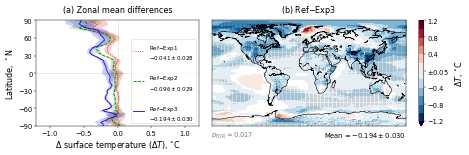

In [11]:
def zonal_mean_exp3_map(variable='TS', f_or_b='b',
                        xlim=[-1.2, 1.2], whiteout='0.05',
                        cmap_name='RdBu_r', nlev=12,
                        mean_format='${:+.3f}\pm{:.3f}$',
                        file_prefix=None):
    # Set-up figure
    fig = plt.figure(figsize=(12, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[2, 3])
    # (a) Zonal mean
    xlabel = '{} ({}), {}'.format(variable_long_dict[variable],
                                  variable_symbol_dict[variable],
                                  variable_units_dict[variable])
    title = '(a) Zonal mean differences'
    ax = zonal_mean_line_plot(variable=variable, f_or_b=f_or_b,
                              xlabel=xlabel, xlim=xlim,
                              ylabel=True, mean_format=mean_format,
                              title=title,
                              ax=plt.subplot(gs[0, 0]))
    # (b) Ref - Exp3 map
    ax, im, tm_diff = difference_map(variable=variable, f_or_b=f_or_b,
                                     ref_scenario='2000', scenario='eas0c',
                                     vlim=xlim, whiteout=whiteout,
                                     cmap_name=cmap_name, nlev=12, colorbar=True,
                                     mean_format=mean_format,
                                     title='(b) Ref$-$Exp3',
                                     ax=plt.subplot(gs[0, 1]))
    # Prevent overlapping labels
    fig.tight_layout()
    # Save
    if file_prefix:
        fig.savefig('local/{}.pdf'.format(file_prefix), bbox_inches='tight', dpi=300)
        print('Written local/{}.pdf'.format(file_prefix))
    return fig
    
# Examples 
if True:
    zonal_mean_exp3_map(file_prefix='temp')